# Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import os

# Load Data

In [3]:
if not os.path.exists("./drive"):
    drive.mount('/content/drive')

if not os.path.exists("../data"):
    os.mkdir("../data")

# loading the temp.zip and creating a zip object
with ZipFile("./drive/MyDrive/train_data.zip", 'r') as zip_object:

    # Extracting all the members of the zip 
    # into a specific location.
    zip_object.extractall(path="../data")


Mounted at /content/drive


In [4]:
n_images: int = 50_000
n_noisy: int = 40_000
n_clean: int = n_images - n_noisy

images : np.ndarray = np.empty((n_images, 32, 32, 3), dtype=np.float32)

# Load the data
for i in range(n_images):
    image_path = f"../data/images/{i+1:05d}.png"
    images[i,:,:,:] = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [6]:
IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

(array([1005.,  974., 1032., 1016.,  999.,  937., 1030., 1001., 1025.,
         981.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

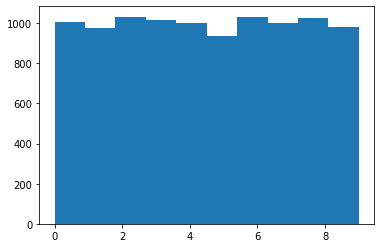

In [ ]:
plt.hist(clean_labels)

### Generate rotations

In [ ]:
def generate_rotations(image: np.ndarray) -> np.ndarray:
    """
    Generate a clockwise rotations of an image with a periodicity of 90 degrees
    
    Parameters
    ----------
    image : np.ndarray
        The image to rotate
    """
    
    # Hortizontal flip the image
    image_flipped = cv2.flip(image, 1)

    # Rotate the image 90 degrees
    image_rotate_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image_rotate_90_flipped = cv2.rotate(image_flipped, cv2.ROTATE_90_CLOCKWISE)

    # Rotate the image 180 degrees
    image_rotate_180 = cv2.rotate(image_rotate_90, cv2.ROTATE_90_CLOCKWISE)
    image_rotate_180_flipped = cv2.rotate(image_rotate_90_flipped, cv2.ROTATE_90_CLOCKWISE)

    # Rotate the image 270 degrees
    image_rotate_270 = cv2.rotate(image_rotate_180, cv2.ROTATE_90_CLOCKWISE)
    image_rotate_270_flipped = cv2.rotate(image_rotate_180_flipped, cv2.ROTATE_90_CLOCKWISE)



    rotated_images = np.array([
        image, image_flipped,
        image_rotate_90, image_rotate_90_flipped,
        image_rotate_180, image_rotate_180_flipped,
        image_rotate_270, image_rotate_270_flipped
    ])

    return rotated_images

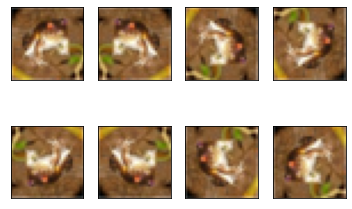

In [ ]:
test_images = generate_rotations(images[0])
for i, img in enumerate(test_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(cv2.resize(img, (32, 32)) / 255.0)
    plt.xticks([]) ## remove the ticks on x-axis
    plt.yticks([]) ## remove the ticks on y-axis
plt.show()

# Model Selection

## Model Selection: Autoencoder + CNN

In [ ]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters = 32, 
        kernel_size = (14, 14),
        activation = 'relu',
        padding = "same",
        strides = 2,
        input_shape = IMG_SHAPE
    ),
    tf.keras.layers.Conv2D(
        filters = 64, 
        kernel_size = (7, 7),
        activation = 'relu',
        padding = "same",
        strides = 2,
    ),
    tf.keras.layers.Conv2D(
        filters = 128, 
        kernel_size = (3, 3),
        activation = 'relu',
        padding = "same",
        strides = 2
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 256, activation = "relu"),
    tf.keras.layers.Dense(units = 10)
])

In [ ]:
decoder = tf.keras.Sequential([
    tf.keras.layers.Input(10),
    tf.keras.layers.Dense(units = 256, activation = "relu"), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 128, activation = "relu"),
    tf.keras.layers.Dense(units = np.prod(IMG_SHAPE), activation='sigmoid'),
    tf.keras.layers.Reshape(IMG_SHAPE),
])

In [ ]:
def average_rounded_accuracy(y_true, y_pred):
    r_true = y_true[:, :, :, 0]
    g_true = y_true[:, :, :, 1]
    b_true = y_true[:, :, :, 2]

    r_pred = y_pred[:, :, :, 0]
    g_pred = y_pred[:, :, :, 1]
    b_pred = y_pred[:, :, :, 2]

    r_acc = tf.keras.metrics.binary_accuracy(tf.round(r_true), tf.round(r_pred))
    g_acc = tf.keras.metrics.binary_accuracy(tf.round(g_true), tf.round(g_pred))
    b_acc = tf.keras.metrics.binary_accuracy(tf.round(b_true), tf.round(b_pred))

    return np.mean([r_acc, g_acc, b_acc])

In [ ]:
encoder.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 16, 32)        18848     
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 64)          100416    
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_72 (Dense)            (None, 128)               262272    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 512)             

In [ ]:
decoder.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 256)               2816      
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_77 (Dense)            (None, 512)               131584    
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_78 (Dense)            (None, 128)               65664     
                                                                 
 dense_79 (Dense)            (None, 1152)              148608    
                                                                 
 reshape_38 (Reshape)        (None, 3, 3, 128)       

In [ ]:
autoencoder = tf.keras.Sequential([encoder, decoder])

In [ ]:
autoencoder.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_54 (Sequential)  (None, 10)                655338    
                                                                 
 sequential_55 (Sequential)  (None, 32, 32, 3)         1397475   
                                                                 
Total params: 2,052,813
Trainable params: 2,052,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
x_train_raw = images[:n_clean] / 255.0
x_train_full = np.array([generate_rotations(img) for img in x_train_raw])
x_train_full = x_train_full.reshape((-1, *IMG_SHAPE))
y_train_full = x_train_full

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train_full, y_train_full, test_size=0.2)

In [ ]:
EPOCHS = 100

In [ ]:
history = autoencoder.fit(
    x_train, y_train,
    epochs = EPOCHS,
    batch_size = 128,
    validation_split = 0.15,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/100
425/425 [==============================] - 14s 29ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374 - val_loss: 0.0963 - val_root_mean_squared_error: 0.3103
Epoch 2/100
425/425 [==============================] - 12s 28ms/step - loss: 0.0742 - root_mean_squared_error: 0.2723 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2553
Epoch 3/100
425/425 [==============================] - 12s 28ms/step - loss: 0.0637 - root_mean_squared_error: 0.2525 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2526
Epoch 4/100
425/425 [==============================] - 12s 28ms/step - loss: 0.0634 - root_mean_squared_error: 0.2518 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2525
Epoch 5/100
425/425 [==============================] - 12s 29ms/step - loss: 0.0634 - root_mean_squared_error: 0.2518 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2525
Epoch 6/100
425/425 [==============================] - 12s 29ms/step - loss: 0.0634 - root_mean_squared_error: 0.2518 - val_l

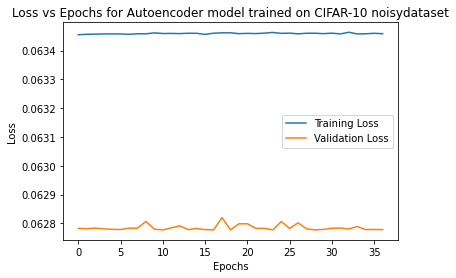

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Autoencoder model " \
          "trained on CIFAR-10 noisydataset")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

1/1 [==============================] - 0s 203ms/step


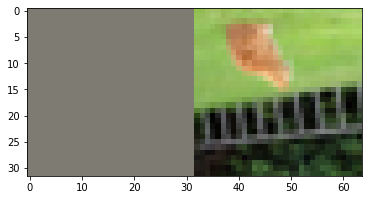

In [ ]:
i = np.random.randint(1, x_train.shape[0] - 1)
p = autoencoder.predict(x_train[(i-1):i])
plt.imshow(np.concatenate([p[0], *x_train[(i-1):i]], axis = 1))
plt.show()

In [ ]:
predictions = autoencoder.predict(y_test)
average_rounded_accuracy(y_test, predictions)

500/500 [==============================] - 1s 3ms/step


0.85128725

### AE + MobileNetV2 + Image Classifier

In [14]:
MobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet', classes = 10)

In [15]:
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [ ]:
autoencoder.trainable=True
MobileNet.trainable=False
image_classifier = tf.keras.Sequential([
    autoencoder,
    MobileNet, 
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 256, activation = "linear"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 512, activation = "sigmoid"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 10)
])

In [ ]:
image_classifier.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
x_train_2 = x_train
y_train_2 = np.array([[c for _ in range(8)] for c in clean_labels]).flatten()

In [ ]:
x_train_2 = x_train_raw[:n_clean]
y_train_2 = clean_labels[:n_clean]

In [ ]:
y_train_2

<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
history_2 = image_classifier.fit(
    x_train_2, y_train_2,
    epochs = 1000,
    batch_size = 128,
    validation_split = 0.20,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=20)],
)

Epoch 1/1000
400/400 [==============================] - 16s 33ms/step - loss: 2.3107 - sparse_categorical_accuracy: 0.1008 - val_loss: 2.3040 - val_sparse_categorical_accuracy: 0.0919
Epoch 2/1000
400/400 [==============================] - 12s 30ms/step - loss: 2.3023 - sparse_categorical_accuracy: 0.1019 - val_loss: 2.3045 - val_sparse_categorical_accuracy: 0.0994
Epoch 3/1000
400/400 [==============================] - 12s 30ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.1004 - val_loss: 2.3049 - val_sparse_categorical_accuracy: 0.0919
Epoch 4/1000
400/400 [==============================] - 12s 30ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.3050 - val_sparse_categorical_accuracy: 0.0919
Epoch 5/1000
400/400 [==============================] - 12s 30ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.1017 - val_loss: 2.3047 - val_sparse_categorical_accuracy: 0.0919
Epoch 6/1000
400/400 [==============================] - 12s 30ms/step - loss: 2.

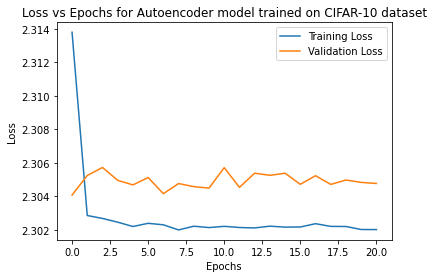

In [ ]:
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Autoencoder model " \
          "trained on CIFAR-10 dataset")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

In [ ]:
p_2 = image_classifier.predict(images[0:1])

1/1 [==============================] - 1s 817ms/step


In [ ]:
p_2.argmax(), clean_labels[0]

(7, 6)

In [20]:
class ImageClassifier(tf.keras.Model):

    def __init__(self, CNN: tf.keras.Model):
        super(ImageClassifier, self).__init__()
        
        # Base CNN model
        self.CNN = CNN

        # Fully connected dense layers
        self.fc_1 = self.keras.layers.Dense(512)
        self.fc_2 = self.keras.layers.Dense(10, activation = "sigmoid")

    def call(self, inputs):
        x = self.CNN(inputs)
        x = self.fc_1(x)
        x = self.fc_2(x)

        return x

In [21]:
class LabelCleaner(tf.keras.Model):

    def __init__(self, CNN: tf.keras.Model):
        super(LabelCleaner, self).__init__()

        # Base CNN model
        self.CNN = CNN

        # Fully connected dense layers
        self.fc_1 = tf.keras.layers.Dense(units = 20)
        self.fc_2 = tf.keras.layers.Dense(units = 512, activation = "relu")
        self.fc_3 = tf.keras.layers.Dense(units = 20)

        # Batch Normalization layers
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.bn_2 = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        
        x = self.CNN(inputs)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.fc_3(x)

        return x

    

In [22]:
MobileNet.trainable = False
label_cleaner_model = LabelCleaner(MobileNet)